In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('laptops.csv')

In [ ]:
# df.head()

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df = df[['ram', 'storage', 'screen', 'final_price']]

EDA

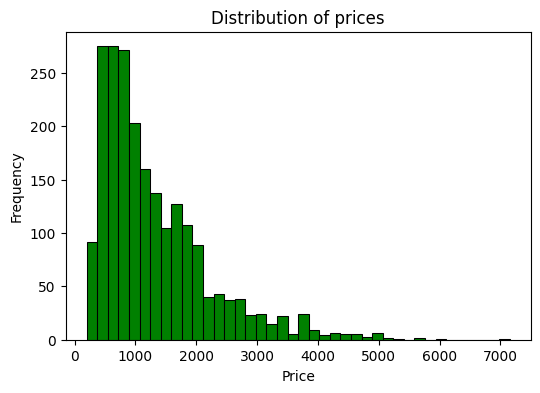

In [5]:
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price, bins=40, color='green', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

There is a long tail

In [6]:
df.isna().any()

ram            False
storage        False
screen          True
final_price    False
dtype: bool

Q1. Column w/ Missing Values:
screen

In [7]:
df.ram.median()

np.float64(16.0)

Q2. RAM Median Value:  16

Prepare and split the dataset

In [8]:
np.random.seed(42)  # use seed to make sure random suffle below is reproducable

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)  # create a range array the size of the df
np.random.shuffle(idx)  # shuffle the array

# create new shuffled version of the df
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [9]:
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

# get log for y values
y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

# remove target values from dfs
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

## Linear Regression

In [10]:
def train_linear_regression(X, y):
    # add the bias term
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [11]:
def prepare_X(df, fill_value):
    df = df.fillna(fill_value)
    X = df.values
    return X

In [12]:
# use train df to get the bias and weights
X_train = prepare_X(df_train, 0)  # fill with 0 first
w_0, w = train_linear_regression(X_train, y_train)

In [13]:
# get the prediction from the train df
y_pred = w_0 + X_train.dot(w)

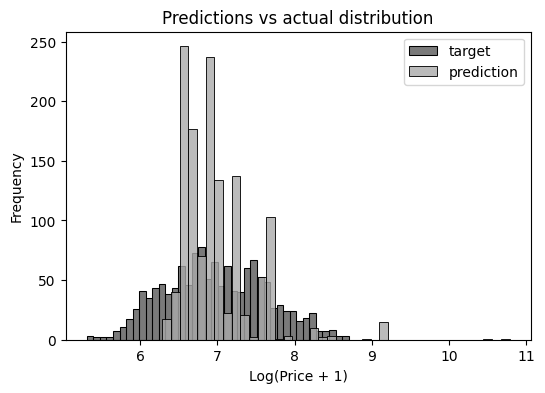

In [14]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

# RMSE

In [16]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    score = np.sqrt(mse)
    return round(score, 2)
    # return round(score, 3)

In [17]:
# use validation df
X_val = prepare_X(df_val, 0)
y_pred = w_0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred))

validation 0.43


In [18]:
# use validation df to get the bias and weights
mean_screen = df_train.screen.mean()  # mean from train df

X_val = prepare_X(df_val, mean_screen)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.43


Q3. RMSE:  Both are equally good

## Regularization

In [19]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [20]:
X_train = prepare_X(df_train, 0)
X_val = prepare_X(df_val, 0)

In [21]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

     0 0.43
  0.01 0.43
   0.1 0.43
     1 0.43
     5 0.46
    10 0.51
   100 0.67


Q4. RMSE:  4 r values produce the same result.  The smallest of the 4 r values is 0.

In [22]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

For each seed:<BR>
Do the train/validation/test split with 60%/20%/20% distribution.<BR>
Fill the missing values with 0<BR>
Train a model without regularization.<BR>
Evaluate the model on the validation dataset and collect the RMSE scores.<BR>

What's the standard deviation of all the scores<BR>
Round the result to 3 decimal digits (round(std, 3))

In [23]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [24]:
rsme_scores = []

for seed_value in seed_values:

    # shuffle the df (based on seed)
    np.random.seed(seed_values[seed_value])

    idx = np.arange(n)  # create a range array the size of the df
    np.random.shuffle(idx)  # shuffle the array

    # create new shuffled version of the df
    df_shuffled = df.iloc[idx]

    # setup the dataframes (train, val)
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()

    y_train_orig = df_train.final_price.values
    y_val_orig = df_val.final_price.values

    # get log for y values
    # y_train = np.log1p(df_train.final_price.values)
    # y_val = np.log1p(df_val.final_price.values)
    y_train = y_train_orig
    y_val = y_val_orig

    # remove target values from dfs
    del df_train['final_price']
    del df_val['final_price']


    # use train df to get the bias and weights
    X_train = prepare_X(df_train, 0)  # fill with 0
    w_0, w = train_linear_regression(X_train, y_train)

    # rmse (validation)
    X_val = prepare_X(df_val, 0)
    y_pred = w_0 + X_val.dot(w)
    # print({seed_value: rmse(y_val, y_pred)})
    rsme_scores.append(rmse(y_val, y_pred))

rsme_scores

[np.float64(565.45),
 np.float64(636.8),
 np.float64(588.96),
 np.float64(597.81),
 np.float64(571.96),
 np.float64(573.24),
 np.float64(647.34),
 np.float64(550.44),
 np.float64(587.33),
 np.float64(576.1)]

In [25]:
np.std(rsme_scores).round(3)

np.float64(29.176)

Q5: 29.176

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [26]:
seed_value = 9

# shuffle the df (based on seed)
np.random.seed(seed_value)

idx = np.arange(n)  # create a range array the size of the df
np.random.shuffle(idx)  # shuffle the array

# create new shuffled version of the df
df_shuffled = df.iloc[idx]

# df_train = df_shuffled.iloc[:n_train].copy()
# df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_train_plus_val = df_shuffled.iloc[:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

# y_train_orig = df_train.final_price.values
# y_val_orig = df_val.final_price.values
y_train_plus_val_orig = df_train_plus_val.final_price.values
y_test_orig = df_test.final_price.values

# # get log for y values
# y_train = np.log1p(df_train.final_price.values)
# y_val = np.log1p(df_val.final_price.values)
# y_test = np.log1p(df_test.final_price.values)

# remove target values from dfs
# del df_train['final_price']
# del df_val['final_price']
del df_train_plus_val['final_price']
del df_test['final_price']

In [27]:
regularization_value = 0.001

# use train df to get the bias and weights
X_train_plus_val = prepare_X(df_train_plus_val, 0)  # fill with 0
w_0, w = train_linear_regression_reg(X_train_plus_val, y_train_plus_val_orig, regularization_value)

In [28]:
# rmse (validation)
X_test = prepare_X(df_test, 0)
y_pred = w_0 + X_test.dot(w)
print({seed_value: rmse(y_test_orig, y_pred)})

{9: np.float64(608.61)}


Q6. 608.60